In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time  # <--- Added for timing
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error



Training Helper Model...
0:	learn: 13.6688108	total: 141ms	remaining: 28.1s
100:	learn: 3.7083420	total: 235ms	remaining: 231ms
199:	learn: 3.2098012	total: 355ms	remaining: 0us

   TUNING CATBOOST (With Time Indicators)
1. Training Base Model (CatBoost)...
0:	learn: 13.7227648	total: 1.57ms	remaining: 783ms
100:	learn: 9.0350400	total: 130ms	remaining: 513ms
200:	learn: 8.4548300	total: 277ms	remaining: 412ms
300:	learn: 7.9294667	total: 425ms	remaining: 281ms
400:	learn: 7.4823019	total: 573ms	remaining: 141ms
499:	learn: 7.0969914	total: 697ms	remaining: 0us
   > Base Model MAE: 7.70 MPa
   > Time taken for Base Model: 1.01 seconds

2. Training Correction Model (Temp + Rainfall)...
   > Running Grid Search (This may take a minute)...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
   > Best Settings Found: {'depth': 2, 'iterations': 100, 'learning_rate': 0.01}
   > Time taken for Tuning: 22.59 seconds

3. Validating Full System...
   > FINAL MAE: 3.29 MPa
   > TOTAL PIP

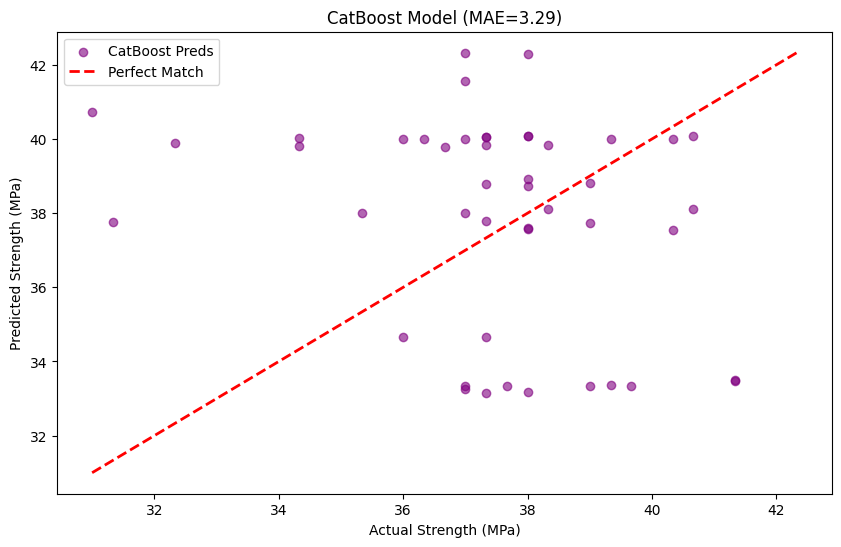

In [2]:
# --- 1. LOAD DATA ---
df_kaggle = pd.read_csv("Data/zainfaisal_pakistan_concrete_data.csv")
df_local = pd.read_csv("Data/localdataset.csv")



# --- 3. HELPER FUNCTION ---
def train_helper_data(df):
    recipe_cols = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 
                   'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate']
    df.columns = df.columns.str.strip() 
    
    # Train Helper
    print("Training Helper Model...")
    df_7 = df[df['Age'] == 7].copy()
    X_helper = df_7[recipe_cols]
    y_helper = df_7['Strength']
    
    # verbose=100 will print progress every 100 iterations
    helper_model = CatBoostRegressor(
        iterations=200, learning_rate=0.1, depth=3, random_state=42, 
        verbose=100  # <--- Shows progress and remaining time
    )
    helper_model.fit(X_helper, y_helper)

    # Impute
    df_28 = df[df['Age'] == 28].copy()
    df_28['Predicted_Strength_7'] = helper_model.predict(df_28[recipe_cols])
    
    df_7_grouped = df_7.groupby(recipe_cols)['Strength'].mean().reset_index()
    df_7_grouped = df_7_grouped.rename(columns={'Strength': 'Real_Strength_7'})
    
    df_augmented = pd.merge(df_28, df_7_grouped, on=recipe_cols, how='left')
    df_augmented['Strength_7'] = df_augmented['Real_Strength_7'].fillna(df_augmented['Predicted_Strength_7'])
    
    final_dataset = df_augmented[['Strength_7', 'Strength']].copy().rename(columns={'Strength': 'Strength_28'})
    return final_dataset

# --- 4. TUNED CATBOOST PIPELINE WITH TIMERS ---
def process_tuned_catboost(df_helper, df_local):
    total_start = time.time() # Start global timer

    print("\n" + "="*40)
    print("   TUNING CATBOOST (With Time Indicators)")
    print("="*40)

    # A. TRAIN BASE MODEL
    print("1. Training Base Model (CatBoost)...")
    start_base = time.time()
    
    X_base = df_helper[['Strength_7']]
    y_base = df_helper['Strength_28']
    
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.2, random_state=42)
    
    # verbose=100 prints every 100 trees. It shows "remaining: 1s" etc.
    base_model = CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=4,
        random_state=42,
        verbose=100  # <--- Change to 0 to hide, or 100 to see updates
    )
    base_model.fit(X_train_b, y_train_b)
    
    base_preds = base_model.predict(X_test_b)
    print(f"   > Base Model MAE: {mean_absolute_error(y_test_b, base_preds):.2f} MPa")
    print(f"   > Time taken for Base Model: {time.time() - start_base:.2f} seconds")

    # B. TRAIN CORRECTION MODEL
    print("\n2. Training Correction Model (Temp + Rainfall)...")
    start_corr = time.time()
    
    df_local['Base_Pred_Lab'] = base_model.predict(df_local[['Strength_7']])
    df_local['Residual'] = df_local['Strength_28'] - df_local['Base_Pred_Lab']
    
    X_corr = df_local[['avgTemp', 'Rainfall_Code']]
    y_corr = df_local['Residual']
    
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_corr, y_corr, test_size=0.2, random_state=42)
    
    # Grid Search
    param_grid = {
        'iterations': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [2, 4, 6]
    }
    
    print("   > Running Grid Search (This may take a minute)...")
    
    # verbose=2 in GridSearchCV prints every fold's completion time
    cb_search = GridSearchCV(
        CatBoostRegressor(random_state=42, verbose=0), # Internal verbose off to avoid spam
        param_grid,
        cv=3,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=2 # <--- This prints "Fitting 3 folds for each of 9 candidates..."
    )
    cb_search.fit(X_train_c, y_train_c)
    
    correction_model = cb_search.best_estimator_
    print(f"   > Best Settings Found: {cb_search.best_params_}")
    print(f"   > Time taken for Tuning: {time.time() - start_corr:.2f} seconds")

    # C. FINAL VALIDATION
    print("\n3. Validating Full System...")
    
    test_inputs_base = df_local.loc[X_test_c.index, ['Strength_7']]
    pred_base_part = base_model.predict(test_inputs_base)
    
    test_inputs_corr = X_test_c
    pred_corr_part = correction_model.predict(test_inputs_corr)
    
    final_predictions = pred_base_part + pred_corr_part
    actual_values = df_local.loc[X_test_c.index, 'Strength_28']
    
    final_mae = mean_absolute_error(actual_values, final_predictions)
    
    print(f"   > FINAL MAE: {final_mae:.2f} MPa")
    print(f"   > TOTAL PIPELINE TIME: {time.time() - total_start:.2f} seconds")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, final_predictions, color='purple', alpha=0.6, label='CatBoost Preds')
    min_val = min(min(actual_values), min(final_predictions))
    max_val = max(max(actual_values), max(final_predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Match')
    plt.xlabel("Actual Strength (MPa)")
    plt.ylabel("Predicted Strength (MPa)")
    plt.title(f"CatBoost Model (MAE={final_mae:.2f})")
    plt.legend()
    plt.show()
    
    return base_model, correction_model

# --- 5. EXECUTE ---
df_helper = train_helper_data(df_kaggle)
base_model_cb, correction_model_cb = process_tuned_catboost(df_helper, df_local)

In [3]:

# 1. Base Model (Kaggle Data)
# CatBoost is data hungry. We feed it the helper data.
X_base = df_helper[['Strength_7']]
y_base = df_helper['Strength_28']

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

# depth=4 keeps it simple for the base curve
base_cb = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=4, verbose=False, random_state=42)
base_cb.fit(X_train_b, y_train_b)

print(f"Base CatBoost MAE: {mean_absolute_error(y_test_b, base_cb.predict(X_test_b)):.2f} MPa")

# 2. Correction Model (Local Data)
df_local['Base_Pred_Lab'] = base_cb.predict(df_local[['Strength_7']])
df_local['Residual'] = df_local['Strength_28'] - df_local['Base_Pred_Lab']

X_corr = df_local[['avgTemp']]
y_corr = df_local['Residual']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_corr, y_corr, test_size=0.2, random_state=42)

# We must be very careful with depth here to avoid overfitting the small local data
corr_cb = CatBoostRegressor(iterations=200, learning_rate=0.05, depth=3, verbose=False, random_state=42)
corr_cb.fit(X_train_c, y_train_c)

# 3. Final Validation
test_inputs_base = df_local.loc[X_test_c.index, ['Strength_7']]
test_inputs_corr = X_test_c

final_pred = base_cb.predict(test_inputs_base) + corr_cb.predict(test_inputs_corr)
actual = df_local.loc[X_test_c.index, 'Strength_28']

print(f"FINAL CATBOOST MAE: {mean_absolute_error(actual, final_pred):.2f} MPa")

Base CatBoost MAE: 7.70 MPa
FINAL CATBOOST MAE: 3.18 MPa
